<a href="https://colab.research.google.com/github/Wnjoki/Data-Science-Exercises/blob/main/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib

trainset_url = "https://storage.googleapis.com/ibeans/train.zip"
data_dir = tf.keras.utils.get_file('train.zip', origin=trainset_url, extract=True)
data_dir = pathlib.Path(data_dir).parent / 'train'  




valset_url = "https://storage.googleapis.com/ibeans/validation.zip"
data_dir1 = tf.keras.utils.get_file('validation.zip', origin=valset_url, extract=True)
data_dir1 = pathlib.Path(data_dir1).parent /'validation'



In [3]:
#list of classes in the data and the number of images in the training set
for sub_dir in data_dir.glob('*'):
    if sub_dir.is_dir():
        image_count = len(list(sub_dir.glob('*.jpg')))
        print(f"{sub_dir.name}: {image_count} images")
        

angular_leaf_spot: 345 images
healthy: 341 images
bean_rust: 348 images


In [4]:
#total images in the  datasets
image_count = len(list(data_dir.glob('**/*.jpg')))
print("Total Images for training:", image_count)

image_count = len(list(data_dir1.glob('**/*.jpg')))
print("Total Images for validation:", image_count)


Total Images for training: 1034
Total Images for validation: 133


Opening some images

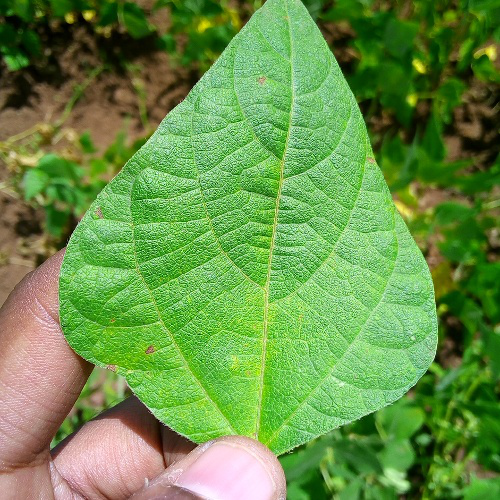

In [5]:
healthy = list(data_dir.glob('healthy/*'))
PIL.Image.open(str(healthy[0]))

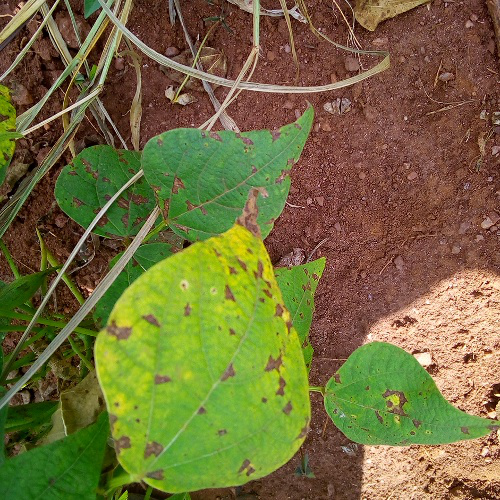

In [6]:
angular_leaf_spot = list(data_dir.glob('angular_leaf_spot/*'))
PIL.Image.open(str(angular_leaf_spot[0]))

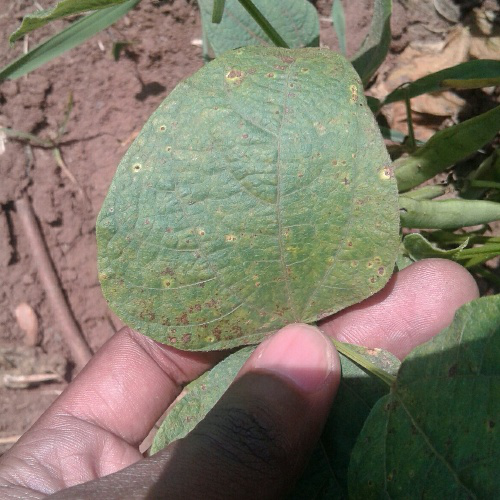

In [7]:
bean_rust = list(data_dir.glob('bean_rust/*'))
PIL.Image.open(str(bean_rust [0]))

Create the dataset

In [8]:
#parameters for the loader
batch_size = 16
img_height = 120
img_width = 120

In [9]:
#I already have the data splits thus only creating the datasets without using validation split
train_set = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_set = tf.keras.utils.image_dataset_from_directory(
  data_dir1,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.


In [10]:
class_names = train_set.class_names
print(class_names)

['angular_leaf_spot', 'bean_rust', 'healthy']


Visualize the data

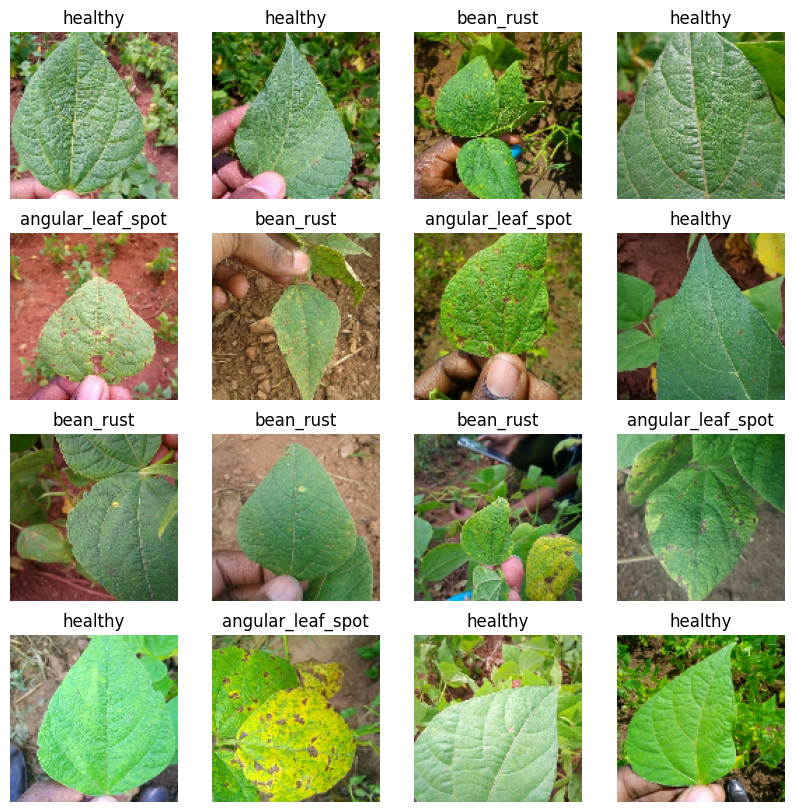

In [11]:
import matplotlib.pyplot as plt
#12 images from the training set
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
#batches of images
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(16, 120, 120, 3)
(16,)


The image_batch is a tensor of the shape (16, 120, 120, 3).  

cache() used to cache the data in memory after it is loaded to improve the training speed. The subsequent epochs of training will not need to re-read the data from disk, hense faster training iterations.

shuffle()used to shuffle the data samples, reducing any potential bias that may arise due to ordering in the dataset. The shuffle() method takes an argument buffer_size which represents the number of elements from the dataset to use for shuffling.

prefetch() used to overlap the data loading and model execution helping to hide the data loading latency while the model is training on the current batch. The buffer_size argument specifies the number of elements to prefetch. 

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
val_set = val_set.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
#standardize the data
normalization_layer = layers.Rescaling(1./255)

In [15]:
normalized_set = train_set.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_set))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


In [16]:
#create model
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [17]:
#compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 120, 120, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        1

Input Layer
rescaling_1: A Rescaling layer that normalizes the input image data by scaling the pixel values between 0 and 1.

Convolutional Layers
conv2d: A 2D convolutional layer with 16 filters, each of size 3x3. It applies the convolution operation to extract features from the input image.
max_pooling2d: A max-pooling layer with a pool size of 2x2. It downsamples the spatial dimensions of the input by taking the maximum value within each region.
conv2d_1: Another 2D convolutional layer with 32 filters of size 3x3.
max_pooling2d_1: Another max-pooling layer with a pool size of 2x2.
conv2d_2: A third 2D convolutional layer with 64 filters of size 3x3.
max_pooling2d_2: A third max-pooling layer with a pool size of 2x2.


Flatten Layer
flatten: A layer that flattens the output from the previous layer into a 1D vector. It converts the multi-dimensional feature maps into a single vector representation.


Dense Layers:
dense: A fully connected dense layer with 128 units. It performs a linear transformation on the input data and applies an activation function.
dense_1: A second dense layer with 3 units, corresponding to the number of classes in the classification task.

The Total params value represents the total number of trainable parameters in the model,including the weights and biases of each layer.

In [19]:
#Train the model
epochs=10
model_results = model.fit(
  train_set,
  validation_data=val_set,
  epochs=epochs
)

Epoch 1/10
65/65 [==============================] - 24s 332ms/step - loss: 1.0069 - accuracy: 0.4884 - val_loss: 0.8163 - val_accuracy: 0.6541
Epoch 2/10
65/65 [==============================] - 19s 293ms/step - loss: 0.7268 - accuracy: 0.6663 - val_loss: 0.5839 - val_accuracy: 0.7669
Epoch 3/10
65/65 [==============================] - 22s 333ms/step - loss: 0.5963 - accuracy: 0.7311 - val_loss: 0.6359 - val_accuracy: 0.6842
Epoch 4/10
65/65 [==============================] - 20s 311ms/step - loss: 0.5512 - accuracy: 0.7708 - val_loss: 0.5652 - val_accuracy: 0.7444
Epoch 5/10
65/65 [==============================] - 25s 380ms/step - loss: 0.5165 - accuracy: 0.7747 - val_loss: 0.5078 - val_accuracy: 0.7970
Epoch 6/10
65/65 [==============================] - 19s 295ms/step - loss: 0.4428 - accuracy: 0.8182 - val_loss: 0.4789 - val_accuracy: 0.8045
Epoch 7/10
65/65 [==============================] - 22s 332ms/step - loss: 0.3453 - accuracy: 0.8569 - val_loss: 0.7180 - val_accuracy: 0.7444

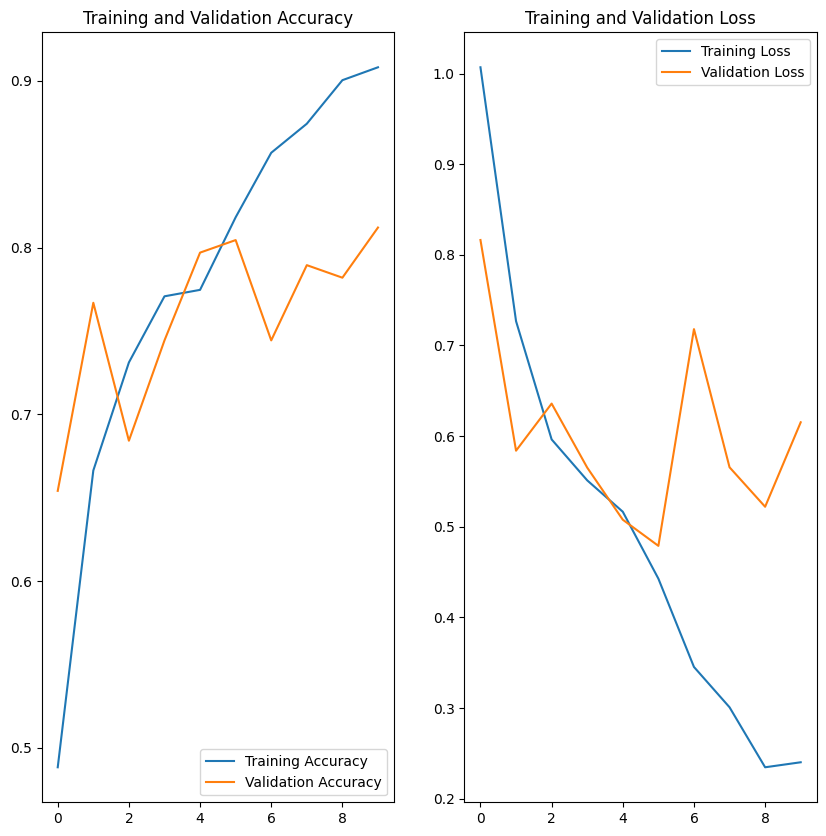

In [20]:
#Visualize training results
acc = model_results.history['accuracy']
val_acc = model_results.history['val_accuracy']

loss = model_results.history['loss']
val_loss = model_results.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots  training accuracy and validation accuracy are off  margins, and the model has achieved only around 80% accuracy on the validation set.

The training accuracy is increasing linearly over time, whereas validation accuracy stalls around 80% in the training process. This is a sign of overfitting.


To deal with overfitting in the training process use data augmentation and add dropout.
Data augmentation is a  technique used to increase the size and diversity of the training dataset, helping to  improve the model's generalization.

Dropout randomly "dropp out" (setting to zero) a  proportion of the input units or neurons during each training step.Thus helps to reduce the interdependencies between neurons and forces the network to learn more robust and generalizable features.

In [21]:
#data_augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

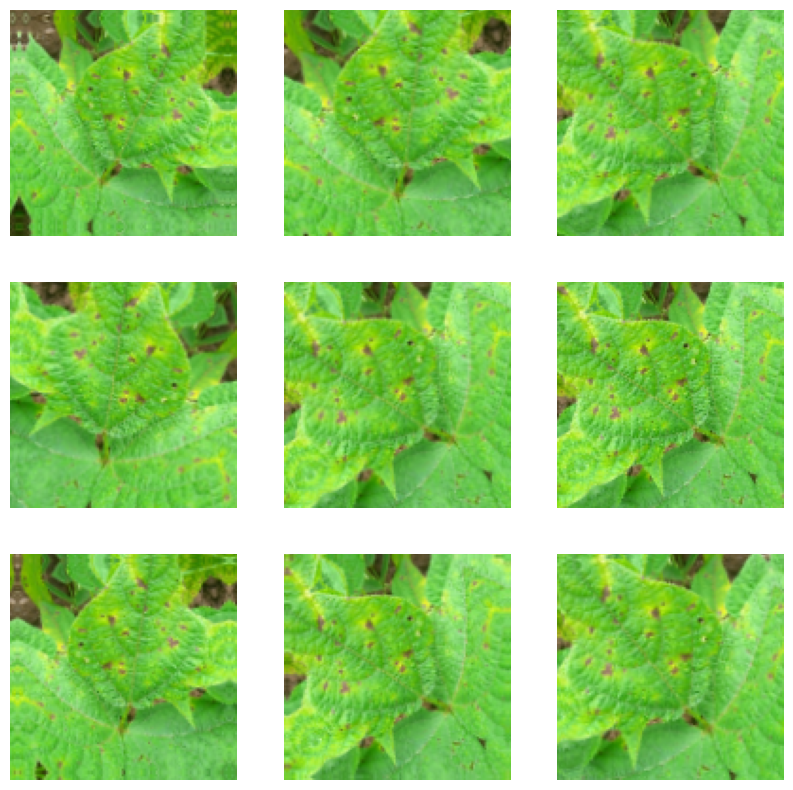

In [22]:
#Visualize a few augmented 
plt.figure(figsize=(10, 10))
for images, _ in train_set.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [23]:
#dropout
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [24]:
#compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 120, 120, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 120, 120, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 120, 120, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 60, 60, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                  

In [26]:
epochs = 15
history = model.fit(
  train_set,
  validation_data=val_set,
  epochs=epochs
)

Epoch 1/15
65/65 [==============================] - 26s 377ms/step - loss: 1.0421 - accuracy: 0.4478 - val_loss: 0.8569 - val_accuracy: 0.5338
Epoch 2/15
65/65 [==============================] - 24s 363ms/step - loss: 0.8299 - accuracy: 0.6277 - val_loss: 0.7847 - val_accuracy: 0.6617
Epoch 3/15
65/65 [==============================] - 23s 348ms/step - loss: 0.7646 - accuracy: 0.6480 - val_loss: 0.6625 - val_accuracy: 0.7218
Epoch 4/15
65/65 [==============================] - 22s 343ms/step - loss: 0.6807 - accuracy: 0.7031 - val_loss: 0.7575 - val_accuracy: 0.7293
Epoch 5/15
65/65 [==============================] - 23s 349ms/step - loss: 0.6739 - accuracy: 0.6973 - val_loss: 0.6507 - val_accuracy: 0.6692
Epoch 6/15
65/65 [==============================] - 24s 365ms/step - loss: 0.6679 - accuracy: 0.7099 - val_loss: 0.9226 - val_accuracy: 0.6316
Epoch 7/15
65/65 [==============================] - 22s 342ms/step - loss: 0.5935 - accuracy: 0.7679 - val_loss: 0.5791 - val_accuracy: 0.7669

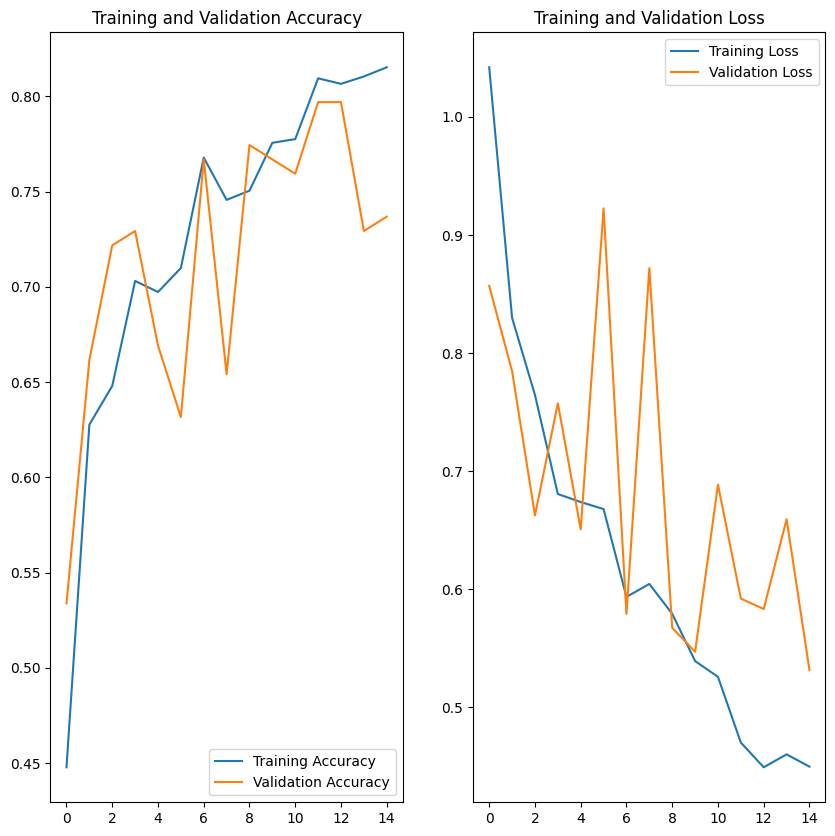

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
#Predict on new data
from google.colab import drive
import zipfile
import os
import glob
drive.mount('/content/drive')


beanImg_path = "/content/drive/MyDrive/Colab Notebooks/Assignment Images-20230604"

#  list of all image files in the folder
bean_files = glob.glob(os.path.join(beanImg_path, "*.jpg"))
print(bean_files)


# Iterate over the image files
for bean_file in bean_files:
   img = tf.keras.utils.load_img(bean_file, target_size=(img_height, img_width))
   img_array = tf.keras.utils.img_to_array(img)
   img_array = tf.expand_dims(img_array, 0)  # Create a batch

   predictions = model.predict(img_array)
   score = tf.nn.softmax(predictions[0])

   class_label = class_names[np.argmax(score)]
   confidence = 100 * np.max(score)

   print(f"Image: {bean_file}")
   print(f"Predicted class: {class_label}")
   print(f"Confidence: {confidence:.2f}%")
   print()
   

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/MyDrive/Colab Notebooks/Assignment Images-20230604/20230531_110123.jpg', '/content/drive/MyDrive/Colab Notebooks/Assignment Images-20230604/20230531_110138.jpg', '/content/drive/MyDrive/Colab Notebooks/Assignment Images-20230604/20230531_110151.jpg', '/content/drive/MyDrive/Colab Notebooks/Assignment Images-20230604/20230531_110321.jpg', '/content/drive/MyDrive/Colab Notebooks/Assignment Images-20230604/20230531_110229.jpg', '/content/drive/MyDrive/Colab Notebooks/Assignment Images-20230604/20230531_110223.jpg', '/content/drive/MyDrive/Colab Notebooks/Assignment Images-20230604/20230531_110211.jpg', '/content/drive/MyDrive/Colab Notebooks/Assignment Images-20230604/20230531_110258.jpg', '/content/drive/MyDrive/Colab Notebooks/Assignment Images-20230604/20230531_110442.jpg', '/content/drive/MyDrive/Colab Notebooks/Assignment Images-20230604/20